# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

In [ ]:
pip install tensorflow-datasets


In [ ]:
pip install matplotlib


## Import Resources

In [1]:
# TODO: Make all necessary imports.
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json


# Import Keras for model building
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image as keras_image

print("All libraries imported successfully!")


2024-12-24 07:51:04.108455: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-24 07:51:04.108517: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-24 07:51:04.108568: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-24 07:51:04.117846: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


All libraries imported successfully!


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [3]:
pip install scipy


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/93/6b/701776d4bd6bdd9b629c387b5140f006185bd8ddea16788a44434376b98f/scipy-1.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 24.7 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
# TODO: Load the dataset with TensorFlow Datasets.
dataset, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
# TODO: Create a training set, a validation set and a test set.
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']


print(f"Number of training examples: {info.splits['train'].num_examples}")
print(f"Number of validation examples: {info.splits['validation'].num_examples}")
print(f"Number of test examples: {info.splits['test'].num_examples}")

num_classes = info.features['label'].num_classes
print(f"Number of classes: {num_classes}")

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 3/3 [00:00<00:00, 70.95 url/s]
Extraction completed...: 0 file [00:00, ? file/s]
Dl Completed...: 100%|██████████| 3/3 [00:00<00:00, 62.30 url/s]
2024-12-24 07:52:45.824210: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (34)


Dataset oxford_flowers102 downloaded and prepared to /home/student/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
Number of training examples: 1020
Number of validation examples: 1020
Number of test examples: 6149
Number of classes: 102


## Explore the Dataset

In [5]:
# TODO: Get the number of examples in each set from the dataset info.
train_size = info.splits['train'].num_examples
validation_size = info.splits['validation'].num_examples
test_size = info.splits['test'].num_examples

print(f"Training set size: {train_size}")
print(f"Validation set size: {validation_size}")
print(f"Test set size: {test_size}")
# TODO: Get the number of classes in the dataset from the dataset info.
num_classes = info.features['label'].num_classes
print(f"Number of classes: {num_classes}")

Training set size: 1020
Validation set size: 1020
Test set size: 6149
Number of classes: 102


In [6]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for i, (image, label) in enumerate(train_dataset.take(3)):  # Loop through the first 3 images
    print(f"Image {i + 1}: Shape = {image.shape}, Label = {label.numpy()}")

Image 1: Shape = (500, 667, 3), Label = 72
Image 2: Shape = (500, 666, 3), Label = 84
Image 3: Shape = (670, 500, 3), Label = 70


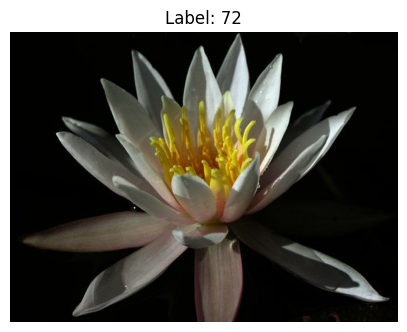

In [7]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding image label. 
import matplotlib.pyplot as plt

for image, label in train_dataset.take(1):  
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title(f"Label: {label.numpy()}")
    plt.show()

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [8]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

Label mapping loaded successfully!
[('0', 'pink primrose'), ('1', 'hard-leaved pocket orchid'), ('2', 'canterbury bells'), ('3', 'sweet pea'), ('4', 'english marigold')]


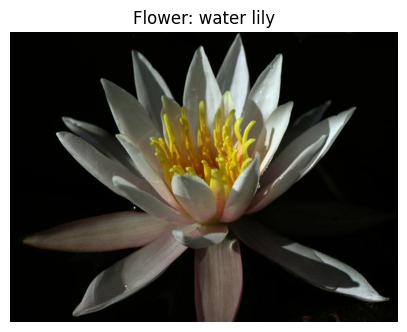

In [9]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 

with open('label_map.json', 'r') as f:
    class_names = json.load(f)

# Print the first few mappings to confirm
print("Label mapping loaded successfully!")
print(list(class_names.items())[:5])  # Print first 5 mappings

for image, label in train_dataset.take(1):  
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title(f"Flower: {class_names[str(label.numpy())]}")
    plt.show()

## Create Pipeline

In [10]:
# TODO: Create a pipeline for each set.

def preprocess_image(image, label):
    # Resize the image to 224x224 and normalize it
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

# Apply preprocessing pipeline to the datasets
BATCH_SIZE = 32

train_dataset = train_dataset.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Datasets preprocessed successfully!")

Datasets preprocessed successfully!


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [11]:
# TODO: Build and train your network.

import tensorflow_hub as hub
from tensorflow.keras import layers, models

# Load the MobileNetV2 feature extractor
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224, 224, 3), trainable=False)

# Build the model
model = models.Sequential([
    feature_extractor_layer,  # Pre-trained feature extractor
    layers.Dense(102, activation='softmax')  # Output layer for 102 flower classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model built and compiled successfully!")

Model built and compiled successfully!


In [12]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.

EPOCHS = 10  # You can increase epochs if needed

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)

print("Model trained successfully!")
import matplotlib.pyplot as plt

Epoch 1/10
32/32 [==============================] - 131s 4s/step - loss: 4.2927 - accuracy: 0.1010 - val_loss: 3.1060 - val_accuracy: 0.3686
Epoch 2/10
32/32 [==============================] - 121s 4s/step - loss: 2.1024 - accuracy: 0.6843 - val_loss: 1.9983 - val_accuracy: 0.6637
Epoch 3/10
32/32 [==============================] - 118s 4s/step - loss: 1.1098 - accuracy: 0.8941 - val_loss: 1.5189 - val_accuracy: 0.7402
Epoch 4/10
32/32 [==============================] - 118s 4s/step - loss: 0.6722 - accuracy: 0.9598 - val_loss: 1.2789 - val_accuracy: 0.7735
Epoch 5/10
32/32 [==============================] - 110s 3s/step - loss: 0.4467 - accuracy: 0.9794 - val_loss: 1.1404 - val_accuracy: 0.7882
Epoch 6/10
32/32 [==============================] - 108s 3s/step - loss: 0.3174 - accuracy: 0.9922 - val_loss: 1.0513 - val_accuracy: 0.7961
Epoch 7/10
32/32 [==============================] - 109s 3s/step - loss: 0.2369 - accuracy: 0.9961 - val_loss: 0.9892 - val_accuracy: 0.8039
Epoch 8/10
32

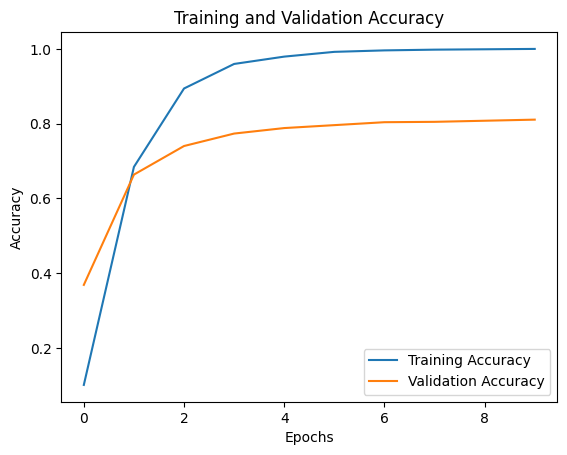

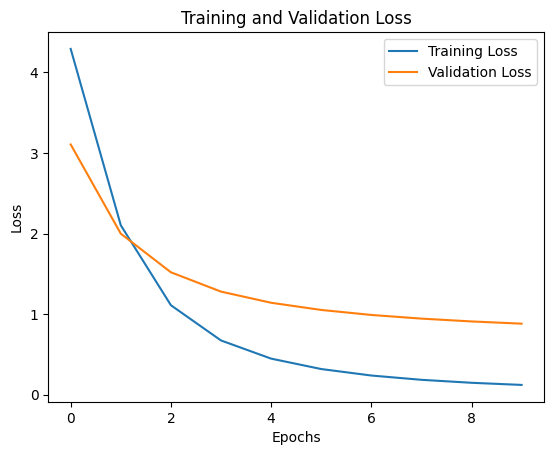

In [13]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [14]:
# TODO: Print the loss and accuracy values achieved on the entire test set.

test_loss, test_accuracy = model.evaluate(test_dataset)

# Print the loss and accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

193/193 [==============================] - 343s 2s/step - loss: 1.0121 - accuracy: 0.7725
Test Loss: 1.0121
Test Accuracy: 0.7725


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [15]:
# TODO: Save your trained model as a Keras model.

model.save('flower_classifier.h5')

print("Model saved successfully as 'flower_classifier.h5'")

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully as 'flower_classifier.h5'


## Load the Keras Model

Load the Keras model you saved above.

In [16]:
# TODO: Load the Keras model

from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('flower_classifier.h5', custom_objects={'KerasLayer': hub.KerasLayer})

print("Model loaded successfully!")

Model loaded successfully!


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [17]:
# TODO: Create the process_image function

def process_image(image):
    """
    Preprocess the input image for the model.
    - Resize to (224, 224)
    - Normalize pixel values to range [0, 1]
    """
    image = tf.convert_to_tensor(image)  # Convert to TensorFlow tensor
    image = tf.image.resize(image, (224, 224))  # Resize to (224x224)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image.numpy()

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

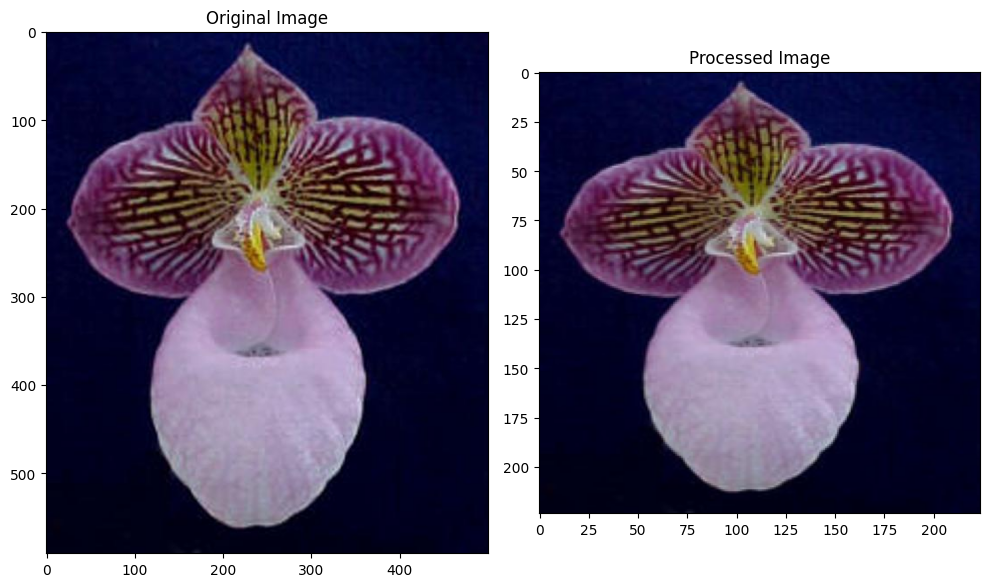

In [18]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [19]:
# TODO: Create the predict function

def predict(image_path, model, top_k=5):
    """
    Predict the top K classes for an image using the trained model.
    Args:
    - image_path (str): Path to the input image.
    - model (Keras Model): The trained Keras model.
    - top_k (int): Number of top predictions to return.
    Returns:
    - top_k_probs (list): Probabilities of the top K classes.
    - top_k_classes (list): Class labels of the top K predictions.
    """
    # Load and preprocess the image
    image = Image.open(image_path)
    image = np.asarray(image)
    processed_image = process_image(image)
    processed_image = np.expand_dims(processed_image, axis=0)  # Add batch dimension

    # Make predictions
    predictions = model.predict(processed_image)
    top_k_probs = np.sort(predictions[0])[-top_k:][::-1]  # Get top K probabilities
    top_k_classes = np.argsort(predictions[0])[-top_k:][::-1]  # Get top K class indices

    return top_k_probs, top_k_classes

In [20]:
image_path = './test_images/hard-leaved_pocket_orchid.jpg'
probs, classes = predict(image_path, loaded_model, top_k=5)

print("Top 5 probabilities:", probs)
print("Top 5 classes:", classes)

1/1 [==============================] - 0s 360ms/step
Top 5 probabilities: [9.9569559e-01 1.0520347e-03 5.6579924e-04 4.9728499e-04 4.3908856e-04]
Top 5 classes: [ 1 67 79 19  6]


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

1/1 [==============================] - 0s 51ms/step


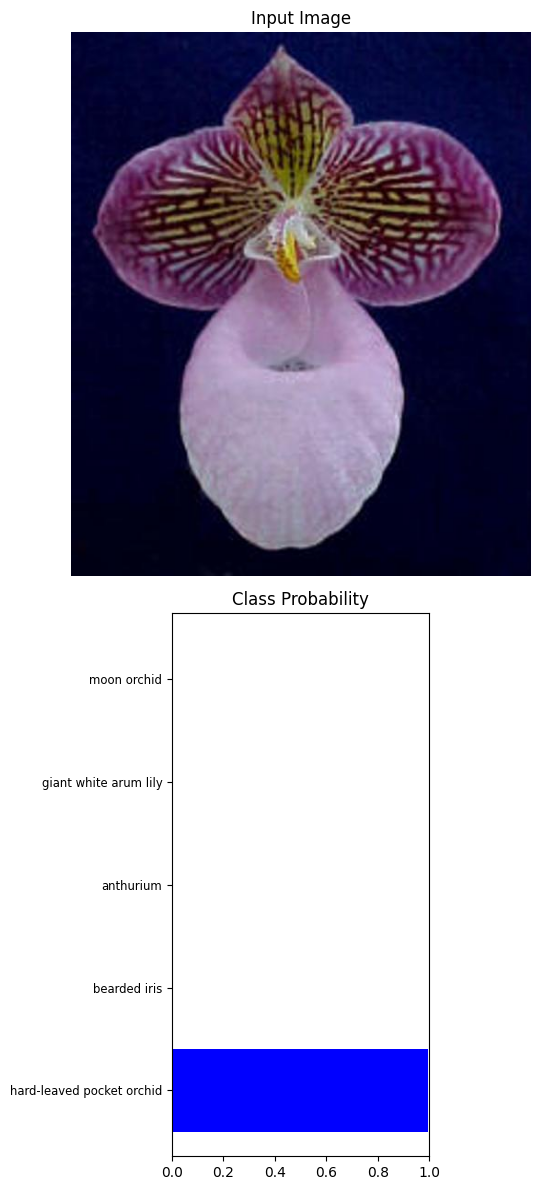

In [21]:
# TODO: Plot the input image along with the top 5 classes
def plot_predictions(image_path, probs, classes, class_names):
    """
    Plot the input image alongside a bar chart of the top 5 class probabilities.
    Args:
    - image_path (str): Path to the input image.
    - probs (list): Probabilities of the top classes.
    - classes (list): Class indices of the top classes.
    - class_names (dict): Mapping of class indices to class names.
    """
    # Load and display the input image
    image = Image.open(image_path)

    plt.figure(figsize=(6, 12))
    ax1 = plt.subplot(2, 1, 1)
    ax1.imshow(image)
    ax1.axis('off')  # Hide axes
    ax1.set_title("Input Image")

    # Map class indices to class names
    class_labels = [class_names[str(cls)] for cls in classes]

    # Plot a bar chart of the top probabilities
    ax2 = plt.subplot(2, 1, 2)
    ax2.barh(class_labels, probs, color='blue')
    ax2.set_aspect(0.4)
    ax2.set_yticks(class_labels)
    ax2.set_yticklabels(class_labels, size='small')
    ax2.set_title("Class Probability")
    ax2.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Predict and plot the results
image_path = './test_images/hard-leaved_pocket_orchid.jpg'
probs, classes = predict(image_path, loaded_model, top_k=5)
plot_predictions(image_path, probs, classes, class_names)